In [1]:
#lets download important library to set up a connection with MYSQL
!pip install mysqlclient

In [4]:
#import the required libraries
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Loading the sql file ibn the database
def exec_sql_file(cursor, sql_file):
    print ("\n[INFO] Executing SQL script file: '%s'" % (sql_file))
    statement = ""

    for line in open(sql_file):
        if re.match(r'--', line):  # ignore sql comment lines
            continue
        if not re.search(r'[^-;]+;', line):  # keep appending lines that don't end in ';'
            statement = statement + line
        else:  # when you get a line ending in ';' then exec statement and reset for next statement
            statement = statement + line
            #print "\n\n[DEBUG] Executing SQL statement:\n%s" % (statement)
            try:
                cursor.execute(statement)
            except (OperationalError, ProgrammingError) as e:
                print ("\n[WARN] MySQLError during execute statement \n\tArgs: '%s'" % (str(e.args)))

            statement = ""
# Let's Create the database using the given SQL File            
sql_file="D:/technical.sql/technical.sql"
mysql_cn= MySQLdb.connect(host='localhost', port=3306,user='root', passwd='Root@123', db='technical_db')
cursor=mysql_cn.cursor()
exec_sql_file(cursor, sql_file)
mysql_cn.close()            


[INFO] Executing SQL script file: 'D:/technical.sql/technical.sql'


In [5]:
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='root', passwd='Root@123', 
                db='technical_db')
unique_isin = pd.read_sql('''SELECT DISTINCT(isin) FROM technical_minute; ''', con=mysql_cn)    
print ('Loaded all the unique isis present in database:\n\n',unique_isin)
mysql_cn.close()

Loaded all the unique isis present in database:

             isin
0      dummy1611
1      dummy3751
2      dummy3811
3   INE180A01020
4   INE195A01028
5   INE221B01012
6   INE265F01028
7   INE271B01025
8   INE298G01027
9   INE397D01024
10  INE436A01026
11  INE451F01016
12  INE492A01029
13  INE545A01016
14  INE885E01034
15  INE916G01016


In [6]:
#Now set up a connection with the database and load our data
#Here I have loaded only a small part of data as resources like RAM were not available
#I have selected the company "INE545A01016" same code cane run for all other companies by changing below
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='root', passwd='Root@123', 
                db='technical_db')
i=int(input("Enter the choice of isin from above list: "));
dict_isin={0:'dummy1611',1:'dummy3751',2:'dummy3811',3:  'INE180A01020',
           4:  'INE195A01028',5:  'INE221B01012',6:  'INE265F01028',
           7:  'INE271B01025',8:  'INE298G01027',9:  'INE397D01024',
           10:  'INE436A01026',11: 'INE451F01016',12: 'INE492A01029',
           13: 'INE545A01016',14: 'INE885E01034',15:'INE916G01016'}
df_mysql = pd.read_sql('''SELECT * FROM technical_minute WHERE isin='%s' ORDER BY datetime ASC; '''% dict_isin.get(i) , con=mysql_cn)    
print ('loaded dataframe from MySQL\n',df_mysql.head())
mysql_cn.close()

Enter the choice of isin from above list: 13
loaded dataframe from MySQL
            isin insertion_datetime            datetime    open    high  \
0  INE545A01016                NaT 2017-04-03 09:15:00  223.45  223.45   
1  INE545A01016                NaT 2017-04-03 09:16:00  223.45  223.45   
2  INE545A01016                NaT 2017-04-03 09:17:00  223.45  223.45   
3  INE545A01016                NaT 2017-04-03 09:18:00  223.45  223.45   
4  INE545A01016                NaT 2017-04-03 09:19:00  223.45  223.45   

      low   close  volume  open_interest  
0  223.45  223.45      20            NaN  
1  223.45  223.45       0            NaN  
2  223.45  223.45       0            NaN  
3  223.45  223.45       0            NaN  
4  223.45  223.45     100            NaN  


C:\Users\amant\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


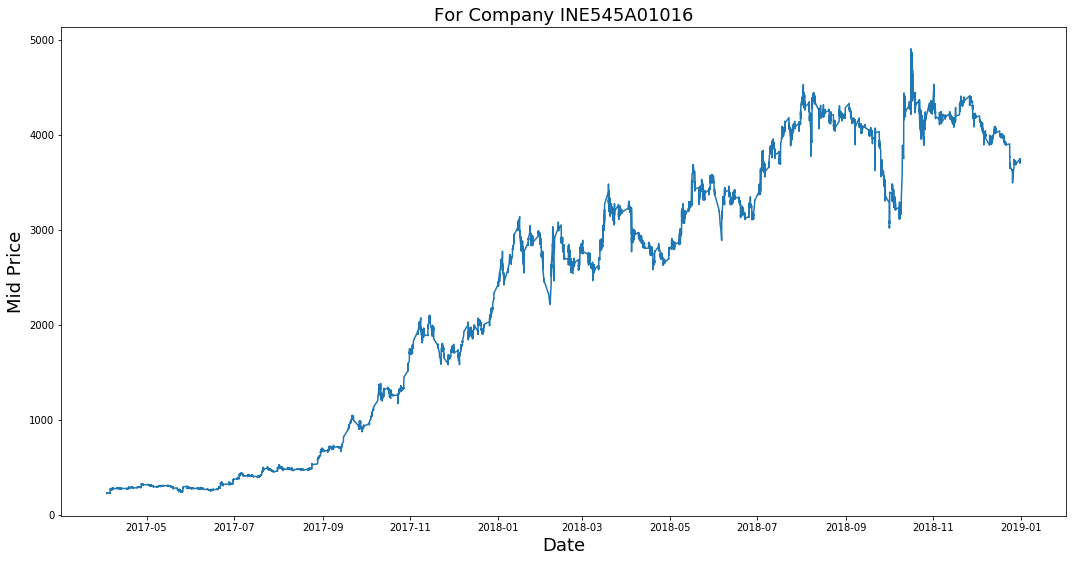

In [7]:
plt.figure(figsize = (18,9))
plt.plot(df_mysql.datetime,(df_mysql.low+df_mysql.high)/2.0)
plt.title('For Company INE545A01016',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [8]:
# dividing data in train and test set in the 50-50 manner
high_prices = np.array(df_mysql.high)
low_prices = np.array(df_mysql.low)
mid_prices = (high_prices+low_prices)/2.0
train_data = mid_prices[:80000];print("Trainning Data Shape: ",train_data.shape)
test_data = mid_prices[80000:];print("Test Data Shape: ",test_data.shape)

Trainning Data Shape:  (80000,)
Test Data Shape:  (81138,)


In [3]:
#Normalize the data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
smoothing_window_size =15000
for di in range(0,70000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


In [4]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(80000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [7]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df_mysql.datetime

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00064


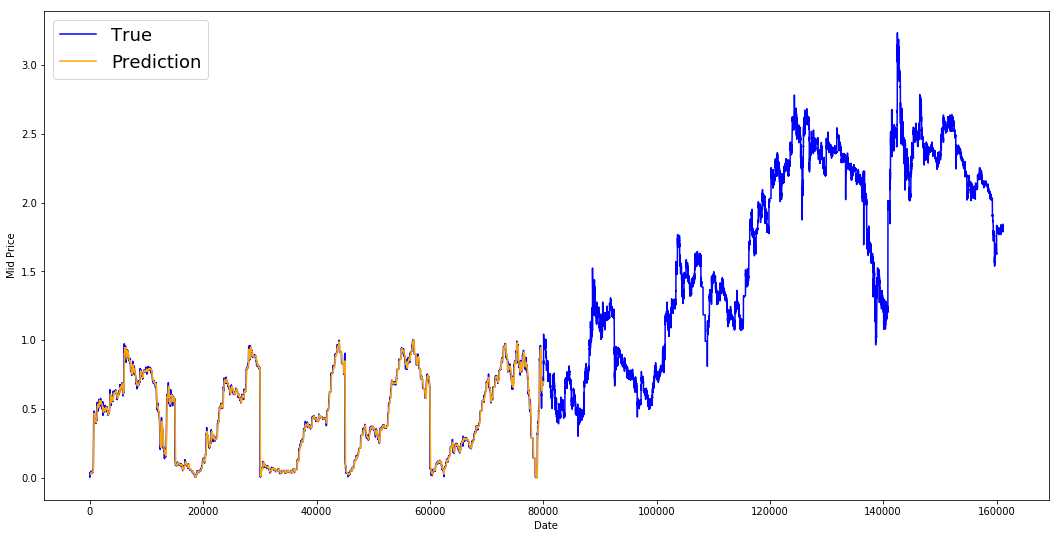

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(train_data.size+test_data.size),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

MSE error for EMA averaging: 0.00000


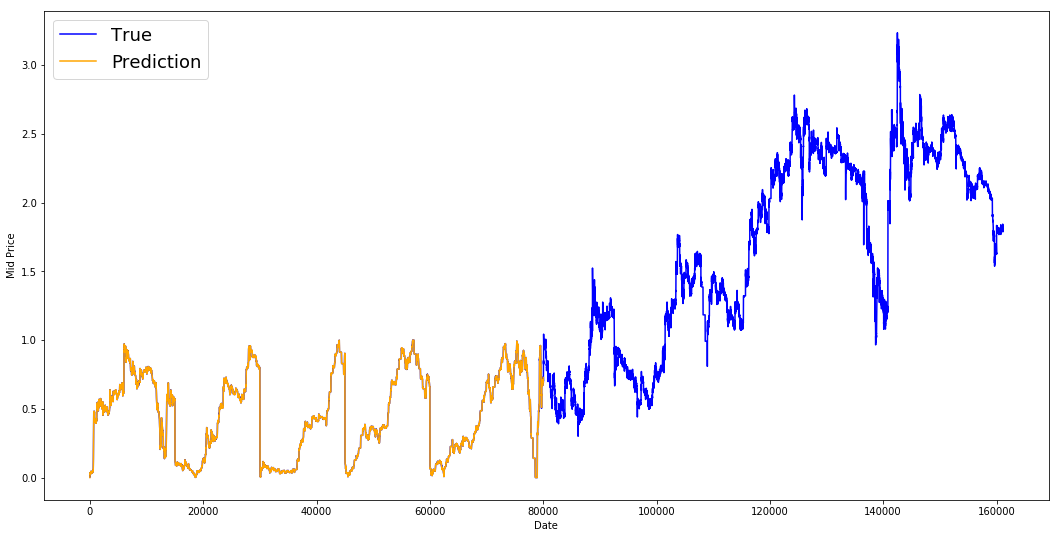

In [9]:
# Here we will demonstrate the exponential moving avereage and show it can easily fit the data more accurately
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


plt.figure(figsize = (18,9))
plt.plot(range(train_data.size+test_data.size),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# LSTM from here on 

In [10]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00285919 0.08620771 0.0439538  0.3072414  0.27630424]

	Output: [0.01170865 0.08636685 0.04422576 0.3072414  0.2762446 ]


Unrolled index 1
	Inputs:  [0.00543245 0.08636685 0.04402173 0.3072414  0.2762446 ]

	Output: [0.00774839 0.08659547 0.04475559 0.3072414  0.27597782]


Unrolled index 2
	Inputs:  [0.00774839 0.08654962 0.04422576 0.3072414  0.27597782]

	Output: [0.01339697 0.08675495 0.04475559 0.3072414  0.2729695 ]


Unrolled index 3
	Inputs:  [0.00983274 0.08659547 0.04435055 0.3072414  0.27549893]

	Output: [0.01339697 0.08678026 0.04475559 0.3072414  0.27472177]


Unrolled index 4
	Inputs:  [0.01170865 0.08661696 0.04447967 0.3072414  0.27472177]

	Output: [0.01751478 0.08695406 0.04523075 0.3072414  0.26781124]


### Hyper_Parameters


In [11]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [12]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

Defining Parameters of the LSTM and Regression layer

In [13]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


### Calculating LSTM output and Feeding it to the regression layer to get final prediction

In [14]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Loss Calculation and Optimizer

In [15]:
print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))
print("\tAll Done")

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All Done


#### Prediction Related Calculations

In [16]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)
print("\tAll Done")

Defining prediction related TF functions
	All Done


#### Running the LSTM

In [17]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(20000,40000,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 0.255614
	Test MSE: 0.00070
	Finished Predictions
Average loss at step 2: 0.026215
	Test MSE: 0.00068
	Finished Predictions
Average loss at step 3: 0.023640
	Test MSE: 0.00067
	Finished Predictions
Average loss at step 4: 0.020647
	Test MSE: 0.00075
	Finished Predictions
Average loss at step 5: 0.020913
	Test MSE: 0.00066
	Finished Predictions
Average loss at step 6: 0.018939
	Test MSE: 0.00074
	Finished Predictions
Average loss at step 7: 0.018854
	Test MSE: 0.00070
	Finished Predictions
Average loss at step 8: 0.017197
	Test MSE: 0.00066
	Finished Predictions
Average loss at step 9: 0.017760
	Test MSE: 0.00115
	Finished Predictions
Average loss at step 10: 0.017350
	Test MSE: 0.00067
	Finished Predictions
Average loss at step 11: 0.015416
	Decreasing learning rate by 0.5
	Test MSE: 0.00076
	Finished Predictions
Average loss at step 12: 0.015174
	Test MSE: 0.00065
	Finished Predictions
Average loss at step 13: 0.014772
	Test MSE: 0.00066
	Finished P

#### Visualizing the predictions
Displaying only a small segement of graph for better visualizations

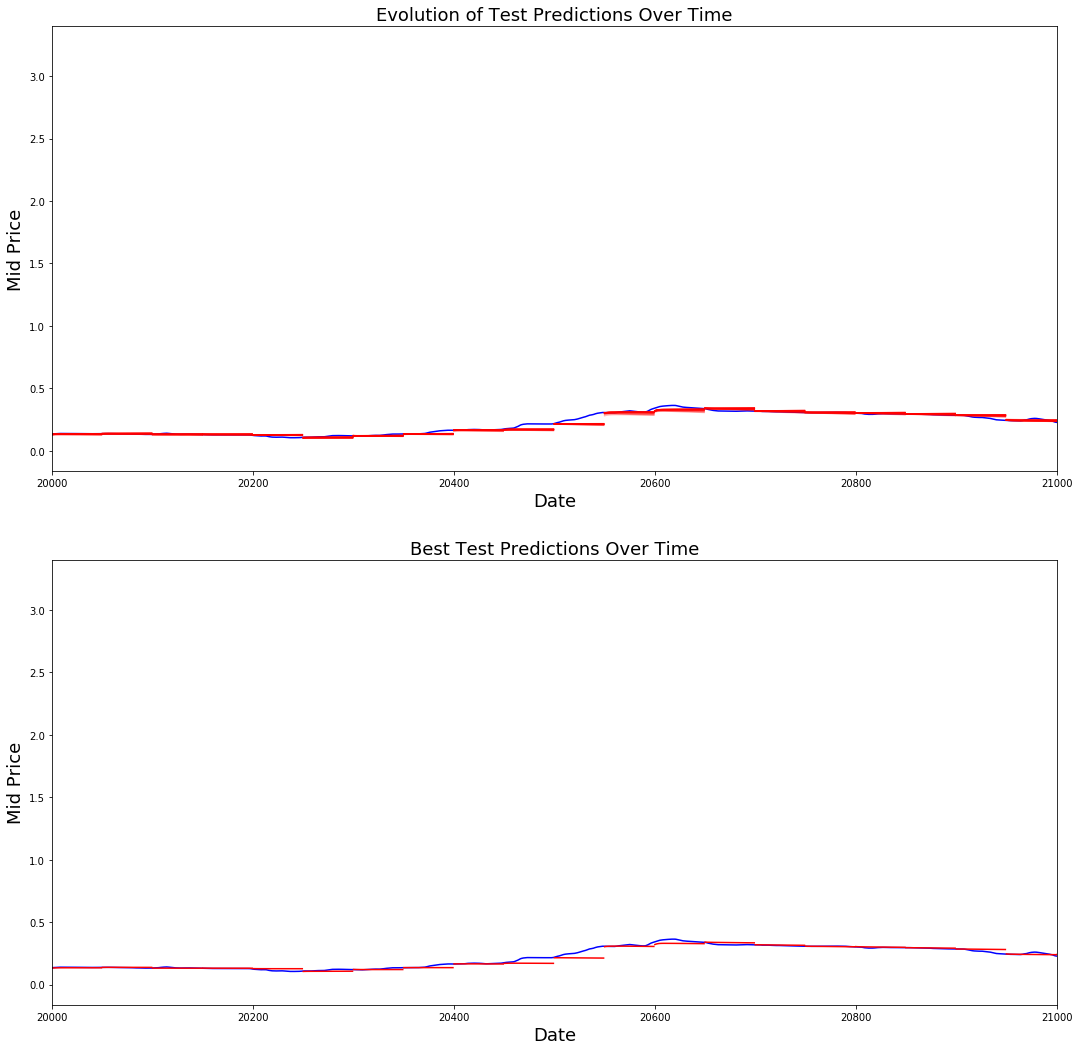

In [29]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(train_data.size+test_data.size),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(20000,21000)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(train_data.size+test_data.size),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(20000,21000)
plt.show()